## Results on AMPDS dataset
source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIE0S4

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import craftai.pandas
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import seaborn as sns
from fbprophet import Prophet
import imp

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#configurating seaborn
palette = sns.color_palette("Set2", 10, 0.9)
sns.set_palette(palette)
sns.set_style("dark")

In [30]:
data = pd.read_csv('data/ampds_power_30T.csv')

In [31]:
data.head()

,date,load
0,1333263600,1947.400000
1,1333265400,1269.766667
2,1333267200,1645.300000
3,1333269000,845.666667
4,1333270800,1584.966667


In [32]:
print('Dataset: {} rows, {} columns'.format(data.shape[0],data.shape[1]))
print(' {:f} % of rows with unknown values'.format((1 -data.dropna().shape[0]/ data.shape[0]) *100))

Dataset: 35040 rows, 2 columns
 0.000000 % of rows with unknown values


In [33]:
# Getting rid of nan values and turning timestamps into datetimes
data.index = pd.to_datetime(data.date, unit="s")
data = data.dropna().drop('date',1)
print('Cleaned dataset: {:d} rows, {:d} columns'.format(data.shape[0],data.shape[1]))
print('Types of data: \n{}'.format(data.dtypes))

Cleaned dataset: 35040 rows, 1 columns
Types of data: 
load    float64
dtype: object


In [34]:
data.head()

,load
date,
2012-04-01 07:00:00,1947.400000
2012-04-01 07:30:00,1269.766667
2012-04-01 08:00:00,1645.300000
2012-04-01 08:30:00,845.666667
2012-04-01 09:00:00,1584.966667


In [35]:
#Adding temperature information
temp = pd.read_csv('data/ampds_temp_30T.csv', parse_dates=['date'])
temp.index = pd.to_datetime(temp.date, unit='s')
temp = temp.drop('date',1)

In [36]:
temp.head()

,temp
date,
2012-04-01 07:00:00,4.7
2012-04-01 07:30:00,4.7
2012-04-01 08:00:00,5.3
2012-04-01 08:30:00,5.3
2012-04-01 09:00:00,5.9


In [40]:
temp.shape == data.shape

True

In [41]:
data = data.merge(temp, left_index=True, right_index=True)

In [42]:
data.head()

,load,temp
date,,
2012-04-01 07:00:00,1947.400000,4.7
2012-04-01 07:30:00,1269.766667,4.7
2012-04-01 08:00:00,1645.300000,5.3
2012-04-01 08:30:00,845.666667,5.3
2012-04-01 09:00:00,1584.966667,5.9


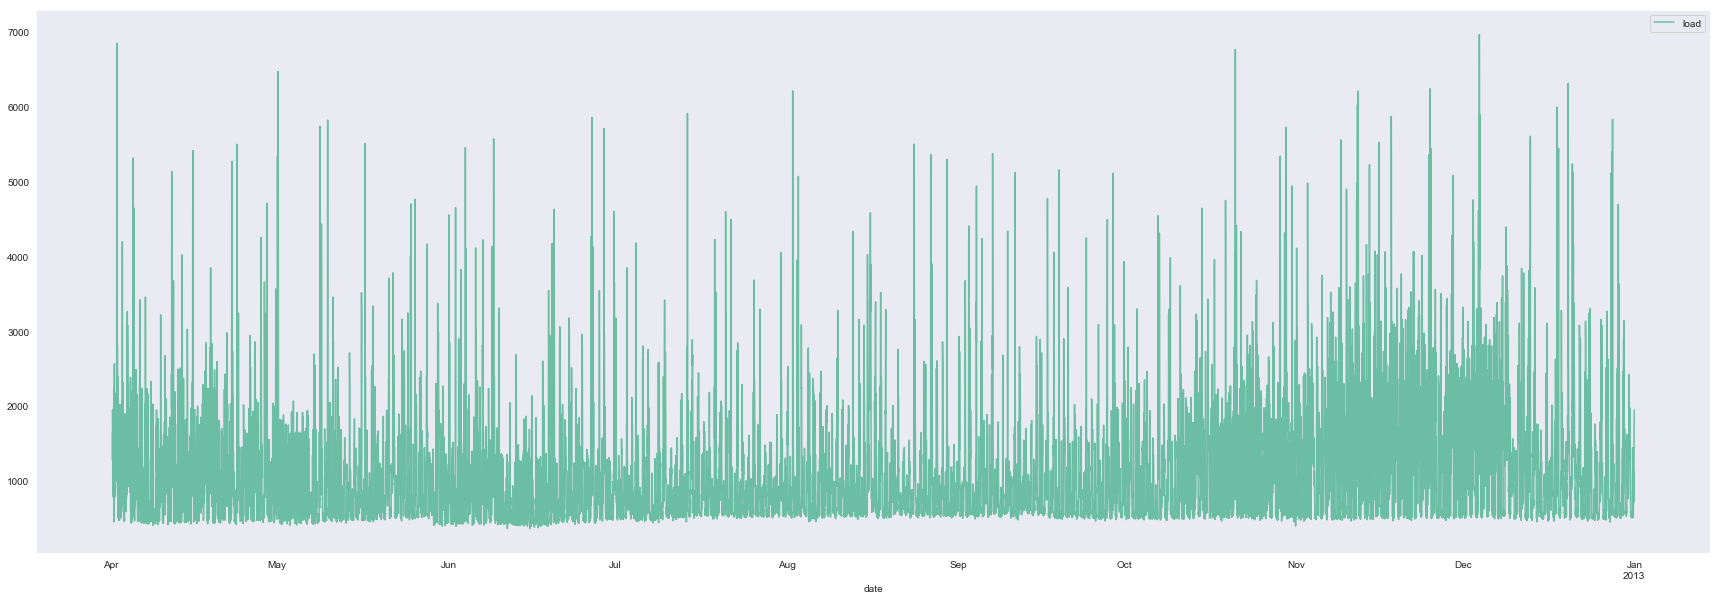

In [43]:
#Plotting the data for year 2012
data_2012 = data[data.index<pd.to_datetime('2013-01-01')]
data_2012 = data_2012.loc[data_2012.index>=pd.to_datetime('2012-01-01')]
data_2012.plot(y='load', figsize=(30,10))
plt.show()

**Splitting the data in train / test**

In [44]:
train_index = int(0.8*data.shape[0])
data_train= data.iloc[:train_index,:]
data_test = data.iloc[train_index:,:]

In [45]:
data_train.head()

,load,temp
date,,
2012-04-01 07:00:00,1947.400000,4.7
2012-04-01 07:30:00,1269.766667,4.7
2012-04-01 08:00:00,1645.300000,5.3
2012-04-01 08:30:00,845.666667,5.3
2012-04-01 09:00:00,1584.966667,5.9


In [46]:
print('Train dataset: {} rows, {} columns'.format(data_train.shape[0],data_train.shape[1]))
print('Test dataset: {} rows, {} columns'.format(data_test.shape[0],data_test.shape[1]))

Train dataset: 28032 rows, 2 columns
Test dataset: 7008 rows, 2 columns


In [47]:
data_test.head()

,load,temp
date,,
2013-11-06 07:00:00,1010.466667,6.5
2013-11-06 07:30:00,575.300000,6.5
2013-11-06 08:00:00,548.966667,6.8
2013-11-06 08:30:00,527.900000,6.8
2013-11-06 09:00:00,597.066667,7.1


**Defining metrics**

In [48]:
def compute_mae(gv, preds):
    '''
    input : 2 arrays with the same dims, output : mean absolute error
    '''  
    return np.round(np.nansum(np.abs(preds- gv))/len(preds))

def compute_rmse(gv, preds):
    '''
    input : 2 arrays with the same dims, output : root mean square error
    '''  
    return np.round(np.sqrt(np.nansum(np.square(preds- gv))/len(preds)))

def compute_mape(gv, preds):
    '''
    input : 2 arrays with the same dims, output : mean absolute percentage error
    '''  
    return np.round(np.nansum(np.abs(preds- gv)/gv)/len(preds),4)*100

### Resultats 

In [85]:
preds_kit10 = pd.read_json("ampds_predictions_10_temp.json", convert_dates=['date'])
preds_kit9 = pd.read_json("ampds_predictions_9_temp.json", convert_dates=['date'])
preds_kit8 = pd.read_json("ampds_predictions_8_temp.json", convert_dates=['date'])
preds_kit7 = pd.read_json("ampds_predictions_7_temp.json", convert_dates=['date'])
preds_kit6 = pd.read_json("ampds_predictions_6_temp.json", convert_dates=['date'])
preds_kit5 = pd.read_json("ampds_predictions_5_temp.json", convert_dates=['date'])
preds_kit4 = pd.read_json("ampds_predictions_4_temp.json", convert_dates=['date'])
preds_kit3 = pd.read_json("ampds_predictions_3_temp.json", convert_dates=['date'])
preds_kit2 = pd.read_json("ampds_predictions_2_temp.json", convert_dates=['date'])

In [86]:
preds = [preds_kit10, preds_kit9, preds_kit8, preds_kit7, preds_kit6, preds_kit5, preds_kit4, preds_kit3, preds_kit2]
maes = []
depth =[]
rmse=[]
d=10
for pred in preds:
    depth.append(d)
    results = pred['predictedLoad'].values
    maes.append(compute_mae(data_test['load'].values,results))
    rmse.append(compute_rmse(data_test['load'].values,results))
    d-=1
kit_tables = pd.DataFrame(data={'depth': depth,'mae': maes, 'rmse': rmse})
kit_tables['score'] = np.round(kit_tables[['mae', 'rmse']].mean(1)/100,2)
kit_tables

,depth,mae,rmse,score
0,10,573.0,848.0,7.10
1,9,568.0,831.0,7.00
2,8,558.0,816.0,6.87
3,7,552.0,792.0,6.72
4,6,558.0,785.0,6.72
5,5,553.0,776.0,6.64
6,4,562.0,776.0,6.69
7,3,541.0,770.0,6.56
8,2,529.0,773.0,6.51


In [87]:
#scores pour la première semaine seulement 
preds = [preds_kit10, preds_kit9, preds_kit8, preds_kit7, preds_kit6, preds_kit5, preds_kit4, preds_kit3, preds_kit2]
maes = []
depth =[]
rmse=[]
d=10
limit = 7*24*2
for pred in preds:
    depth.append(d)
    results = pred['predictedLoad'].values
    maes.append(compute_mae(data_test['load'].values[:limit],results[:limit]))
    rmse.append(compute_rmse(data_test['load'][:limit].values,results[:limit]))
    d-=1
kit_tables = pd.DataFrame(data={'depth': depth,'mae': maes, 'rmse': rmse})
kit_tables['score'] = np.round(kit_tables[['mae', 'rmse']].mean(1)/100,2)
kit_tables

,depth,mae,rmse,score
0,10,675.0,895.0,7.85
1,9,656.0,838.0,7.47
2,8,622.0,811.0,7.16
3,7,633.0,803.0,7.18
4,6,606.0,791.0,6.98
5,5,600.0,788.0,6.94
6,4,570.0,779.0,6.74
7,3,558.0,787.0,6.72
8,2,549.0,792.0,6.70


**Best depth for craft ai : 4**

In [88]:
craft_preds = preds_kit4[['date', 'predictedLoad', 'standardDeviation']].copy(deep=True).set_index('date')
craft_preds['low_predictedLoad'] = craft_preds['predictedLoad'] - craft_preds['standardDeviation']
craft_preds['high_predictedLoad'] = craft_preds['predictedLoad'] + craft_preds['standardDeviation']

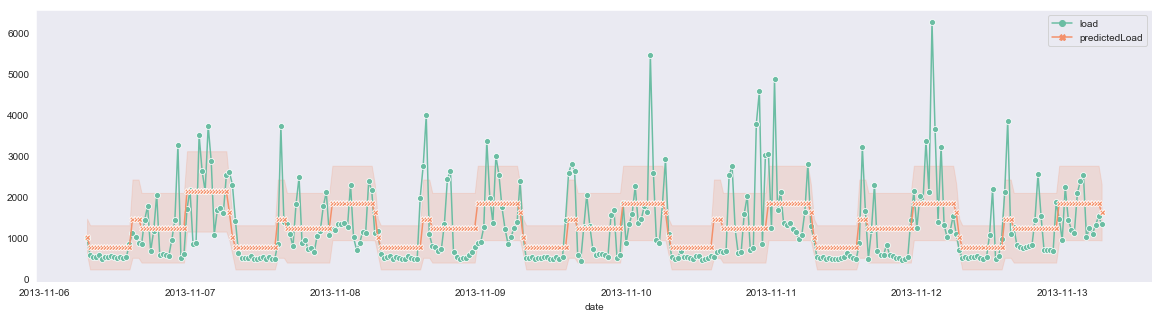

In [89]:
limit = 7*24*2 #On prend la première semaine
fig  = plt.figure(figsize=(20,5))
compare = data_test.merge(craft_preds, right_index=True, left_index=True)
sns.lineplot(data=compare[['load', 'predictedLoad']].iloc[:limit,:], dashes=False, markers=True)
plt.fill_between(compare.index[:limit], compare['low_predictedLoad'][:limit], compare['high_predictedLoad'][:limit], alpha=0.2, color=palette[1])
sns.set_style("dark")

### Scikit Regression Tree

Préparation des données pour sklearn

In [49]:
def get_features_from_index(df):
    new_df = df.copy(deep=True).dropna()
    new_df['hour'] = new_df.index.hour
    new_df['day'] = new_df.index.day
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    return new_df

In [50]:
sk_train = get_features_from_index(data_train)
sk_test = get_features_from_index(data_test)

In [51]:
maes=[]
rmse=[]
depth=[]
for i in range(1,12):
#     print('Training scikit Regressor Tree with a depth of ', i)
    skTree = DecisionTreeRegressor(criterion = 'mse', max_depth=i, random_state=0)
    skTree.fit(sk_train[['hour', 'day', 'month', 'year', 'temp']], sk_train['load'])
    results = skTree.predict(sk_test[['hour', 'day', 'month', 'year', 'temp']])
    maes.append(compute_mae(sk_test['load'].values,results))
    rmse.append(compute_rmse(sk_test['load'].values,results))
    depth.append(i)
sk_tables = pd.DataFrame(data={'depth': depth,'mae': maes, 'rmse':rmse})
sk_tables['score'] = np.round(sk_tables[['mae', 'rmse']].mean(1)/100,2)
sk_tables

,depth,mae,rmse,score
0,1,536.0,810.0,6.73
1,2,517.0,781.0,6.49
2,3,523.0,769.0,6.46
3,4,558.0,775.0,6.66
4,5,543.0,776.0,6.60
5,6,546.0,788.0,6.67
6,7,545.0,788.0,6.66
7,8,540.0,799.0,6.70
8,9,554.0,820.0,6.87
9,10,563.0,848.0,7.06


**Best depth for scikit : 3 !**

In [52]:
skTree = DecisionTreeRegressor(criterion = 'mse', max_depth=3, random_state=0)

In [53]:
skTree.fit(sk_train[['hour', 'day', 'month', 'year', 'temp']], sk_train['load'])

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [54]:
sk_results = skTree.predict(sk_test[['hour', 'day', 'month', 'year', 'temp']])

In [55]:
# print ("craft kit energy", np.round(np.nansum(np.abs(preds_kit8['predictedLoad'].values- data_test['load'].values))/preds_kit8.shape[0],1))
print ("scikit", np.round(np.nansum(np.abs(sk_results- sk_test['load'].values))/sk_test.shape[0],1))

scikit 523.1


In [56]:
type(sk_results)

numpy.ndarray

In [57]:
data_test.head()

,load,temp
date,,
2013-11-06 07:00:00,1010.466667,6.5
2013-11-06 07:30:00,575.300000,6.5
2013-11-06 08:00:00,548.966667,6.8
2013-11-06 08:30:00,527.900000,6.8
2013-11-06 09:00:00,597.066667,7.1


In [58]:
bench = data_test.copy(deep=True).drop('temp',1)
bench['sk_results'] = sk_results

In [59]:
bench.head()

,load,sk_results
date,,
2013-11-06 07:00:00,1010.466667,703.032326
2013-11-06 07:30:00,575.300000,703.032326
2013-11-06 08:00:00,548.966667,703.032326
2013-11-06 08:30:00,527.900000,703.032326
2013-11-06 09:00:00,597.066667,703.032326


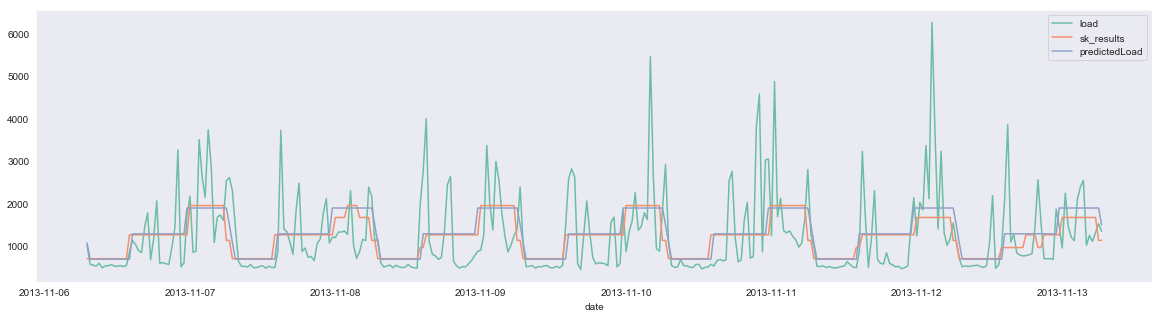

In [140]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1)
bench['sk_results'] = sk_results
bench = bench.merge(craft_preds[['predictedLoad']].iloc[:limit,:], left_index=True, right_index=True)
sns.lineplot(data=bench, dashes=False)
plt.show()

In [14]:
#Benchmark : on the first 5000 entries ! 
data_arima = data_train.iloc[:5000,:]

p=d =q =range(1,2)
pdq= list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 48) for x in pdq]

aics=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data_arima.loc[:,'load'],
                            seasonal_order = param_seasonal,
                            order= param, 
                            exog = data_arima.loc[:,'temp'],
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            aics.append(results.aic)
            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\Claire\Anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 1, 48) - AIC:76522.96088191016


### Random Forest 

In [210]:
# rmse=[]
def random_forest_grid(sk_train, sk_test, metric='mae', max_depth=10, max_n=10):
    depth=[]
    grid=[]
    
    def compute_metric(results):
        if metric=='mape':
            return compute_mape(sk_test['load'].values,results)
        if metric == 'rmse':
            return compute_rmse(sk_test['load'].values,results)
        return compute_mae(sk_test['load'].values,results)
    
    for i in range(2,max_n): # on fait varier la taille de la forêt
        metrics=[]
        for j in range(1,max_depth): # on fait varier la profondeur
        #     print('Training scikit Random Forest Regressor with a depth of ', i)
            skForest = RandomForestRegressor(n_estimators=i, criterion = 'mse', max_depth=j, random_state=0, bootstrap=True)
            skForest.fit(sk_train[['hour', 'day', 'month', 'year', 'temp']], sk_train['load'])
            results = skForest.predict(sk_test[['hour', 'day', 'month', 'year', 'temp']])
            metrics.append(compute_metric(results))
        grid.append(metrics)
    
    depths = ['depth: ' +str(k) for k in np.arange(1,max_depth)]
    skforest_tables = pd.DataFrame(grid, columns = depths, index = np.arange(2,max_n))
    # skforest_tables['score'] = np.round(skforest_tables[['mae', 'rmse']].mean(1)/100,2)
    skforest_tables.index.name = "n_estimators"
    skforest_tables['best'] = np.min(skforest_tables,1)
    
    return skforest_tables

In [213]:
skf_mae_grid = random_forest_grid(sk_train, sk_test, metric='rmse')
skf_mae_grid

,depth: 1,depth: 2,depth: 3,depth: 4,depth: 5,depth: 6,depth: 7,depth: 8,depth: 9,best
n_estimators,,,,,,,,,,
2,811.0,783.0,768.0,775.0,769.0,771.0,775.0,790.0,813.0,768.0
3,811.0,783.0,768.0,774.0,766.0,766.0,770.0,784.0,797.0,766.0
4,811.0,783.0,769.0,771.0,765.0,764.0,768.0,782.0,790.0,764.0
5,811.0,782.0,768.0,772.0,765.0,765.0,768.0,780.0,786.0,765.0
6,810.0,782.0,768.0,772.0,766.0,765.0,769.0,778.0,785.0,765.0
7,810.0,782.0,768.0,772.0,766.0,765.0,768.0,775.0,783.0,765.0
8,810.0,782.0,768.0,772.0,765.0,763.0,766.0,775.0,782.0,763.0
9,810.0,782.0,767.0,772.0,764.0,763.0,765.0,773.0,780.0,763.0


Best parameters for our random forest : 9x6

In [218]:
skForest = RandomForestRegressor(n_estimators=9, criterion = 'mse', max_depth=6, random_state=0, bootstrap=True)
skForest.fit(sk_train[['hour', 'day', 'month', 'year', 'temp']], sk_train['load'])
forest_results = skForest.predict(sk_test[['hour', 'day', 'month', 'year', 'temp']])

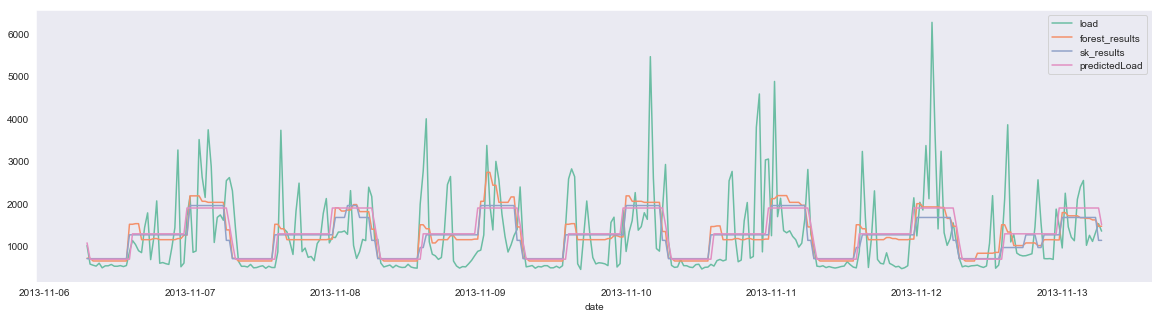

In [219]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1)
bench['forest_results'] = forest_results
bench['sk_results'] = sk_results
bench = bench.merge(craft_preds[['predictedLoad']].iloc[:limit,:], left_index=True, right_index=True)
sns.lineplot(data=bench, dashes=False)
plt.show()

### Fbprophet

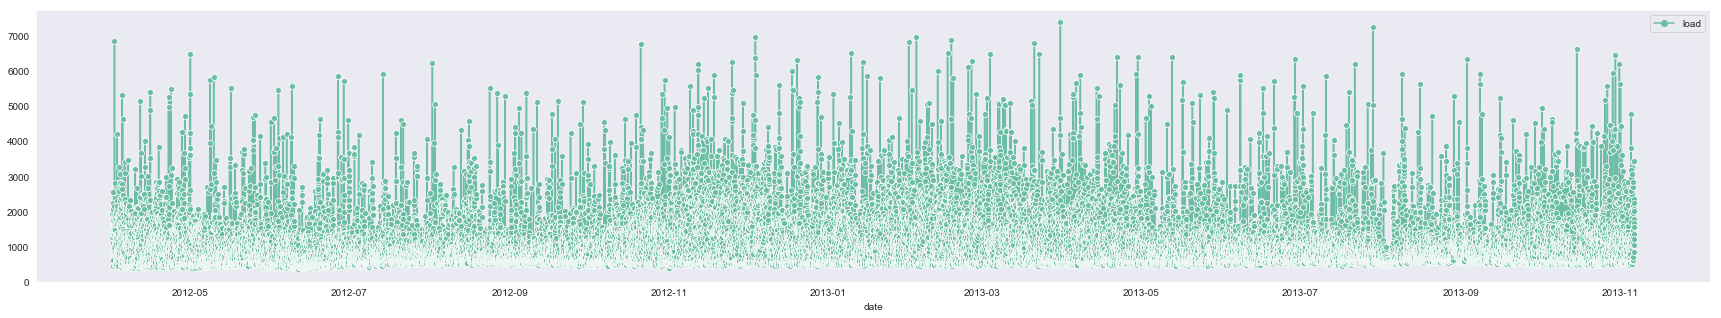

In [105]:
fig  = plt.figure(figsize=(30,5))
sns.lineplot(data=data_train[['load']], dashes=False, markers=True)

In [236]:
data_train.head()

,load,temp
date,,
2012-04-01 07:00:00,1947.400000,4.7
2012-04-01 07:30:00,1269.766667,4.7
2012-04-01 08:00:00,1645.300000,5.3
2012-04-01 08:30:00,845.666667,5.3
2012-04-01 09:00:00,1584.966667,5.9


In [94]:
#Training prophet without temp data
prophet_train = data_train.copy(deep=True)

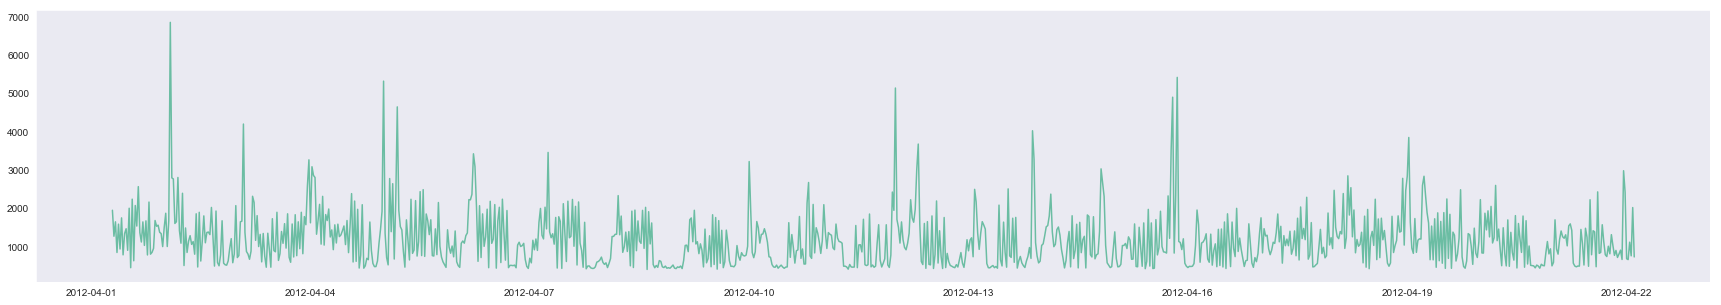

In [107]:
fig  = plt.figure(figsize=(30,5))
sns.lineplot(data=prophet_train.load[:1000], dashes=False, markers=True)

In [95]:
prophet_train = prophet_train.reset_index().rename(columns={'date':'ds', 'load': 'y'})
pm = Prophet()
pm.add_regressor('temp')
pm.fit(prophet_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [111]:
future = data_test.drop('load',1).reset_index().rename(columns={'date':'ds'})
forecast = pm.predict(future)

In [117]:
df_compare = pd.concat([data_test,  forecast[['ds', 'yhat']].set_index('ds'), craft_preds[['predictedLoad']]],1).drop('temp',1)
df_compare['sk_preds'] = sk_results

In [131]:
df_compare.head()

,load,yhat,predictedLoad,sk_preds
date,,,,
2013-11-06 07:00:00,1010.466667,921.221778,1074.49380,703.032326
2013-11-06 07:30:00,575.300000,791.472352,690.73553,703.032326
2013-11-06 08:00:00,548.966667,687.376674,690.73553,703.032326
2013-11-06 08:30:00,527.900000,613.406916,690.73553,703.032326
2013-11-06 09:00:00,597.066667,573.143483,690.73553,703.032326


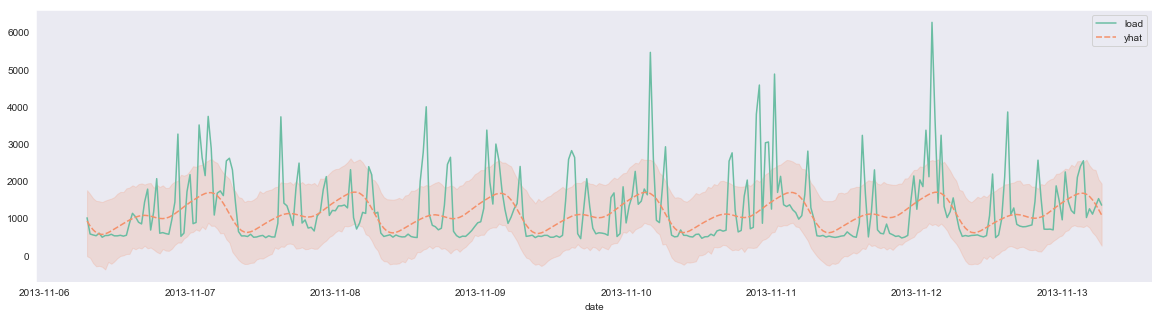

In [170]:
limit = 7*24*2
fig  = plt.figure(figsize=(20,5))
sns.lineplot(data=df_compare[['load', 'yhat']].iloc[:limit,:])
plt.fill_between(x = df_compare.index[:limit], y1 = forecast['yhat_lower'][:limit], y2 = forecast['yhat_upper'][:limit], alpha=0.2, color=palette[1])
plt.show()

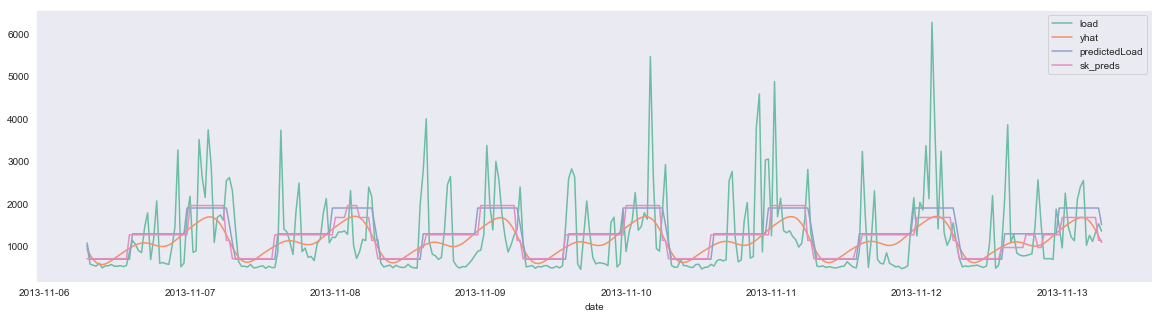

In [220]:
limit = 7*24*2
fig  = plt.figure(figsize=(20,5))
sns.lineplot(data=df_compare.iloc[:limit,:], dashes=False)
plt.show()

**Computing MAE** : 

In [103]:
#print ("craft kit energy", np.round(np.nansum(np.abs(preds_kit8['predictedLoad'].values- data_test['load'].values))/preds_kit8.shape[0],1))
gvs=data_test['load'].values
print ("scikit", compute_mae(gvs, sk_results))
print ("prophet", compute_mae(gvs, df_compare.yhat.values ))

scikit 534.0
prophet 537.0


### Sarima model !

Best parameters on [0,1]^6 computed in arima_grid notebook : SARIMA(1, 0, 1)x(0, 1, 1, 48) for AIC = 76466.42140598648

In [141]:
arima_train = data_train.drop('temp',1)

In [142]:
arima_train.head()

,load
date,
2012-04-01 07:00:00,1947.400000
2012-04-01 07:30:00,1269.766667
2012-04-01 08:00:00,1645.300000
2012-04-01 08:30:00,845.666667
2012-04-01 09:00:00,1584.966667


To avoid memory errors, let's train our ARIMA model on the last 5000 entries only.

In [225]:
model = SARIMAX(data_train.loc[:,'load'].values[-5000:],
                            order= (1,0,1), 
                            seasonal_order = (0,1,1,48),
                            exog = data_train.iloc[-5000:,1],
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
arima_results = model.fit()

C:\Users\Claire\Anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
C:\Users\Claire\Anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


In [226]:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 48)   Log Likelihood              -37792.354
Date:                            Mon, 24 Sep 2018   AIC                          75594.708
Time:                                    15:05:36   BIC                          75627.195
Sample:                                07-25-2013   HQIC                         75606.106
                                     - 11-06-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -7.2216      5.103     -1.415      0.157     -17.223       2.780
ar.L1          0.4075      0.020     19.884      0.000       0.367       0.448
ma.L1          0.0747      0.023      3.186      0.001       0.029       0.121
ma.S.L48      -0.9474      0.003   -285.611      0.000      -0.954      -0.941
sigma2      2.868e+05   2101.089    136.498      0.000    2.83e+05    2.91e+05
===================================================================================
Ljung-Box (Q):                      111.72   Jarque-Bera (JB):             62929.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             2.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

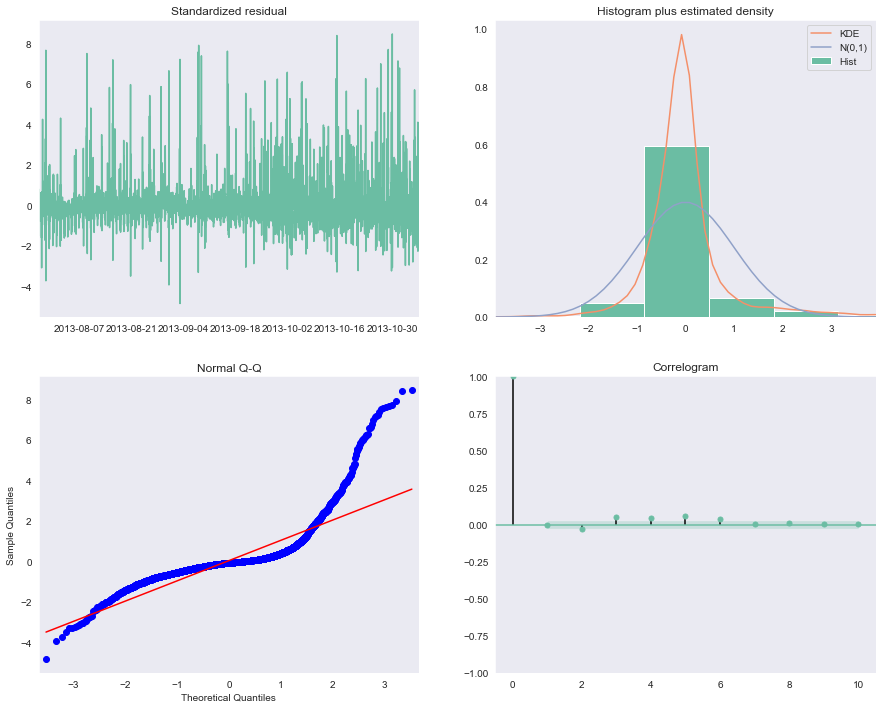

In [227]:
arima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [229]:
limit = 7*24*2
start = 5001
stop = 5001 + limit-2
arima_pred = arima_results.get_prediction(start, stop, dynamic=False, exog = data_test[['temp']].iloc[:limit,:])

In [230]:
arima_preds = arima_pred.predicted_mean
arima_confs = arima_pred.conf_int()

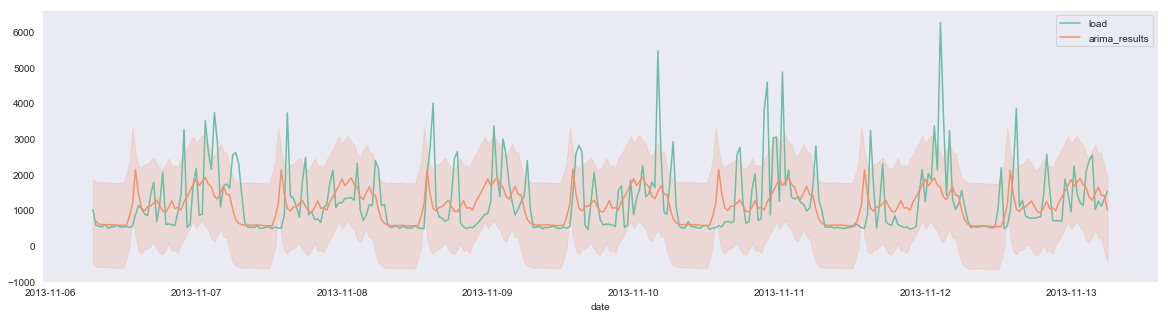

In [232]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1).iloc[:limit-1,:]
bench['arima_results'] = arima_preds
sns.lineplot(data=bench, dashes=False)
plt.fill_between(x=bench.index, y1=arima_confs['lower y'], y2 = arima_confs['upper y'], alpha=0.2, color=palette[1])
plt.show()

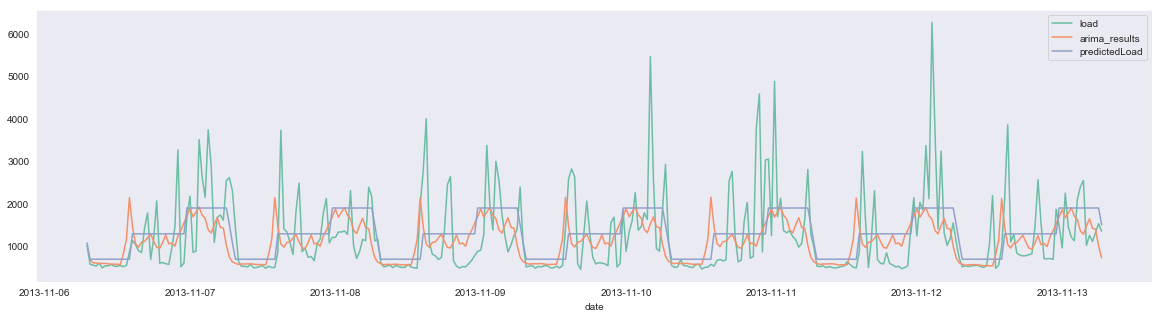

In [233]:
limit=7*24*2
fig  = plt.figure(figsize=(20,5))
bench = data_test.copy(deep=True).drop('temp',1).iloc[:limit,:]
bench['arima_results'] = arima_preds
bench = bench.merge(craft_preds[['predictedLoad']].iloc[:limit,:], left_index=True, right_index=True)
sns.lineplot(data=bench, dashes=False)
plt.show()

### First Benchmark 

In [234]:
ground_values = data_test['load'].values
kit_results , pm_preds= craft_preds['predictedLoad'].values, df_compare.yhat.values
predictions = [kit_results, sk_results, forest_results, pm_preds, arima_preds]
ids= ['craft kit', 'scikit tree', 'scikit forest','prophet', 'sarimax']
maes=[]
mapes=[]
rmse=[]
for pred in predictions:
    gv = ground_values if len(pred) == len(ground_values) else ground_values[:len(pred)]
    maes.append(compute_mae(gv,pred))
    rmse.append(compute_rmse(gv,pred))
    mapes.append(compute_mape(gv,pred))
benchmark = pd.DataFrame(data={
    'ids': ids,
    'mae': maes,
    'mape': mapes,
    'rmse': rmse
})

In [235]:
benchmark

,ids,mae,mape,rmse
0,craft kit,541.0,51.61,770.0
1,scikit tree,523.0,48.82,769.0
2,scikit forest,530.0,50.08,763.0
3,prophet,541.0,53.12,773.0
4,sarimax,592.0,51.84,892.0


### Testing functions from ampds_benchmark_tools

In [140]:
import ampds_benchmark_tools as abt
imp.reload(abt)

<module 'ampds_benchmark_tools' from 'C:\\Users\\Claire\\Documents\\craft-ai-kit-energy\\benchmark\\ampds_benchmark_tools.py'>

In [62]:
data.head()

,load,temp
date,,
2012-04-01 07:00:00,1947.400000,4.7
2012-04-01 07:30:00,1269.766667,4.7
2012-04-01 08:00:00,1645.300000,5.3
2012-04-01 08:30:00,845.666667,5.3
2012-04-01 09:00:00,1584.966667,5.9


In [82]:
week_unit = 7*24*2 #nombre de demi-heures dans une semaine
last_train_index = 50*week_unit
last_test_index = last_train_index + week_unit
tr, tst = abt.split_data(data, last_train_index , last_test_index)

In [89]:
skr = abt.get_scikit_preds(tr, tst)
fore = abt.get_forest_preds(tr, tst)

In [100]:
pmr = abt.get_prophet_preds(tr, tst)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [113]:
cpre = abt.get_craft_preds(stop_train=last_train_index, start_pred=last_train_index, stop_pred=last_test_index, node_file = "load_benchmark_ampds")

In [107]:
sar = abt.get_sarima_preds(tr,tst,week_unit)

C:\Users\Claire\AppData\Local\Continuum\anaconda3\envs\energykit\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


In [115]:
crp = cpre['predictedLoad']
std = cpre['standardDeviation']

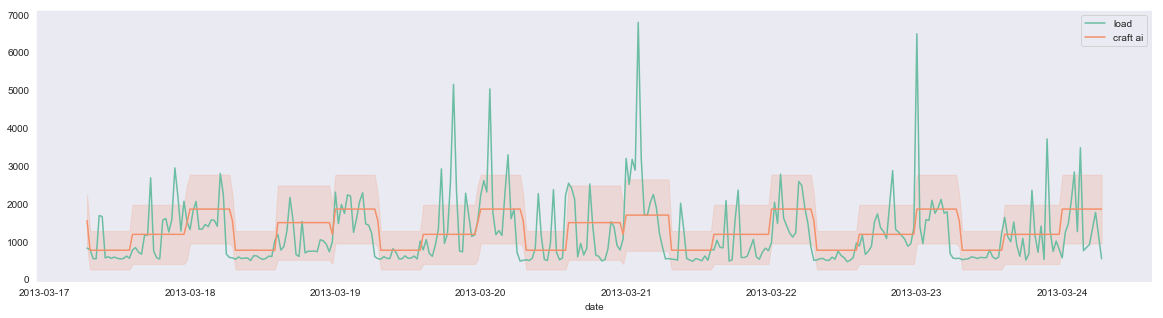

In [133]:
abt.plot_period_predictions(data_test=tst,
                        craft_preds =crp.values,
#                         sk_preds =skr, 
#                         forest_preds=fore, 
#                         pm_preds=pmr, 
#                         sarima_preds=sar, 
                        standardDev = True,
                        low_val =crp- std,
                        upper_val =crp+ std)

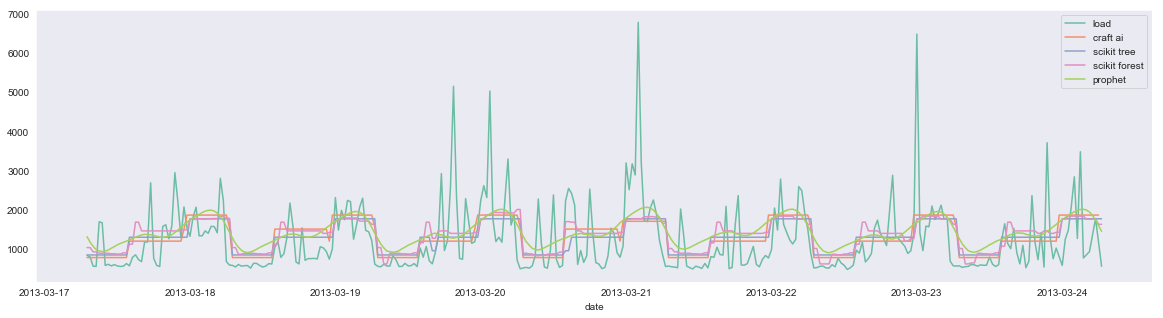

In [134]:
abt.plot_period_predictions(data_test=tst,
                            craft_preds=crp, 
                            sk_preds=skr, 
                            forest_preds=fore, 
                            pm_preds=pmr)

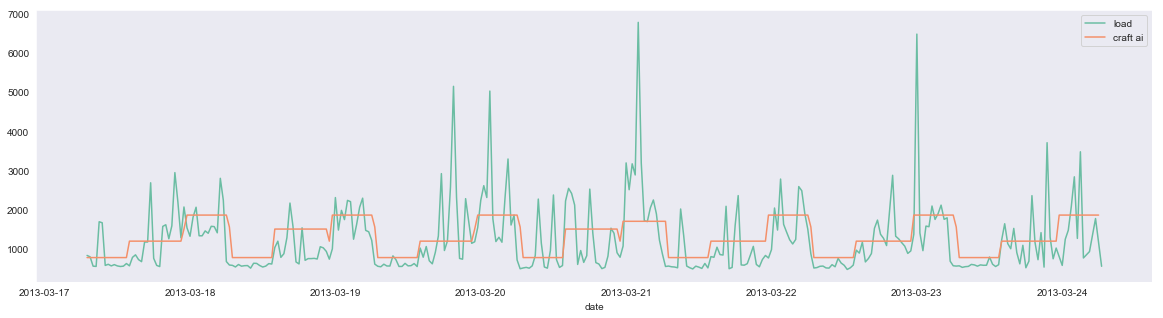

In [135]:
abt.plot_period_predictions(data_test=tst,
                        craft_preds =crp, 
                        standardDev = True)

In [141]:
abt.get_models_scores(data_test=tst,
                      predictions=[skr, fore, pmr, crp], 
                      idx = ['a', 'b', 'c', 'd'])

,ids,mae,mape,rmse,r2
0,a,515.0,51.01,757.0,0.229920
1,b,541.0,56.12,765.0,0.214302
2,c,591.0,64.59,782.0,0.177893
3,d,525.0,51.97,780.0,0.182013
